In [24]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt

In [47]:
def get_snr_sme_results(epochs):
    # Define the time window in seconds
    tmin, tmax = 0.1, 0.3
    epsilon = 1e-10

    # We will calculate SNR, SME for each unique event in the concatenated epochs
    event_ids = epochs.event_id
    snr_results = {}
    sme_results = {}
    event_occurences = {}

    for event_id, _ in event_ids.items():
        # Select epochs for the current event_id
        epochs_specific = epochs[event_id]

        if len(epochs_specific) == 0:
            event_occurences[event_id] = 0
            continue
        
        # Get data and times, restrict to the time window of interest
        data = epochs_specific.get_data(picks='eeg')  # shape: (n_epochs, n_channels, n_times)
        times = epochs_specific.times
        time_window_mask = (times >= tmin) & (times <= tmax)
        
        # Calculate mean amplitude in the specified time window for each epoch
        mean_amplitudes = data[:, :, time_window_mask].mean(axis=2)
        
        # Calculate the average ERP waveform (signal) across epochs for the event_id
        signal = mean_amplitudes.mean(axis=0)
        
        # Calculate the standard deviation across epochs for each channel
        sd = np.std(mean_amplitudes, axis=0)
        
        # Calculate N (the number of epochs for the current event_id)
        N = len(epochs_specific)
        
        # Calculate the Simple Measurement Error (SME) for each channel
        SME = sd / np.sqrt(N)
        
        # Calculate SNR for each channel
        SNR = np.abs(signal) / (SME + epsilon)
        
        # Store the results
        snr_results[event_id] = SNR
        sme_results[event_id] = SME
        event_occurences[event_id] = N

    return snr_results, sme_results, event_occurences

In [26]:
# Path to the directory containing .fif files
fif_dir = os.path.join('..', 'eeg_data', 'final_eeg', '05_125')

# List all .fif files in the directory
fif_files = [f for f in os.listdir(fif_dir) if f.endswith('.fif')]

# Initialize an empty list to hold epochs from all files
all_epochs = []

for fif_file in fif_files:
    processed_fif_path = os.path.join(fif_dir, fif_file)
    epochs = mne.read_epochs(processed_fif_path, preload=True)
    all_epochs.append(epochs)

# Concatenate epochs from all files
concatenated_epochs = mne.concatenate_epochs(all_epochs)

# Calculate SNR and SME for each event in the concatenated epochs
snr_results, sme_results, event_occurences = get_snr_sme_results(concatenated_epochs)

Reading /Users/charles/Developer/all-joined/alljoined_preprocessing/snr/../eeg_data/final_eeg/05_125/subj04_session1_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3752 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/charles/Developer/all-joined/alljoined_preprocessing/snr/../eeg_data/final_eeg/05_125/subj01_session2_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3072 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/charles/Developer/all-joined/alljoined_preprocessing/snr/../eeg_data/final_eeg/05_125/subj04_session2_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3073 matching event

Event Occurences: {'1': 38, '2': 37, '3': 35, '4': 38, '5': 36, '6': 33, '7': 35, '8': 36, '9': 36, '10': 35, '11': 34, '12': 37, '13': 38, '14': 39, '15': 36, '16': 41, '17': 36, '18': 35, '19': 33, '20': 33, '21': 33, '22': 35, '23': 34, '24': 32, '25': 35, '26': 28, '27': 36, '28': 34, '29': 36, '30': 39, '31': 39, '32': 37, '33': 35, '34': 34, '35': 34, '36': 35, '37': 30, '38': 36, '39': 34, '40': 37, '41': 38, '42': 34, '43': 34, '44': 35, '45': 34, '46': 36, '47': 33, '48': 38, '49': 32, '50': 36, '51': 38, '52': 28, '53': 38, '54': 34, '55': 36, '56': 33, '57': 34, '58': 32, '59': 34, '60': 37, '61': 36, '62': 36, '63': 37, '64': 37, '65': 37, '66': 38, '67': 36, '68': 33, '69': 35, '70': 29, '71': 35, '72': 38, '73': 36, '74': 34, '75': 35, '76': 36, '77': 33, '78': 32, '79': 38, '80': 30, '81': 38, '82': 32, '83': 31, '84': 38, '85': 33, '86': 33, '87': 37, '88': 33, '89': 40, '90': 38, '91': 36, '92': 36, '93': 36, '94': 34, '95': 36, '96': 30, '97': 36, '98': 31, '99': 34, 

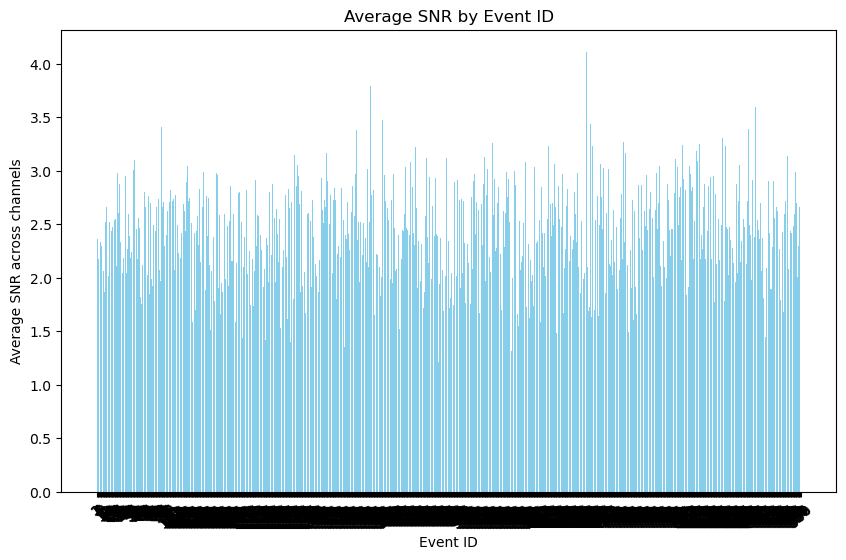

In [27]:

# Optionally, print the SME for each event_id (and each channel, if you wish)
# for event_id, SME in sme_results.items():
#     print(f"Event ID: {event_id}")
#     for i, sme_value in enumerate(SME):
#         print(f"  Channel {i+1}: SME = {sme_value}")

# Plotting SNR for a representative channel or average over channels, if preferred
# For simplicity, let's plot the average SNR across channels for each event ID
average_snr_per_event = {event_id: np.mean(SNR) for event_id, SNR in snr_results.items()}
events = list(average_snr_per_event.keys())
average_snr_values = list(average_snr_per_event.values())
print("Event Occurences:", event_occurences)

plt.figure(figsize=(10, 6))
plt.bar(events, average_snr_values, color='skyblue')
plt.xlabel('Event ID')
plt.ylabel('Average SNR across channels')
plt.title('Average SNR by Event ID')
plt.xticks(rotation=45)
plt.show()


In [33]:
# Path to the directory containing .fif files
fif_dir = os.path.join('..', 'eeg_data', 'final_eeg', '05_125')

# List all .fif files in the directory
fif_files = [f for f in os.listdir(fif_dir) if f.endswith('.fif')]

# Getting average SNR for each subject, averaged across all event IDs and channels
session_epochs = {}

for fif_file in fif_files:
    session_id = (' ').join(fif_file.split('_')[0:2])
    processed_fif_path = os.path.join(fif_dir, fif_file)
    epochs = mne.read_epochs(processed_fif_path, preload=True)
    session_epochs[session_id] = epochs

Reading /Users/charles/Developer/all-joined/alljoined_preprocessing/snr/../eeg_data/final_eeg/05_125/subj04_session1_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3752 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/charles/Developer/all-joined/alljoined_preprocessing/snr/../eeg_data/final_eeg/05_125/subj01_session2_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3072 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/charles/Developer/all-joined/alljoined_preprocessing/snr/../eeg_data/final_eeg/05_125/subj04_session2_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3073 matching event

In [50]:
# Calculate SNR and SME for each event in the concatenated epochs
average_snr_per_session = {}

for session_id, epochs in session_epochs.items():
    print(f"Beginning calculations on {session_id}")
    snr_results, sme_results, event_occurences = get_snr_sme_results(epochs)
    print(f"Event Occurences: {event_occurences}")
    for event_id, event_occurences in event_occurences.items():
        if event_occurences == 0:
            print(f"Event ID {event_id} has 0 occurences")
    average_snr_per_event = {event_id: np.mean(SNR) for event_id, SNR in snr_results.items()}

    # Remove events with above average SNR
    removed_events = []
    for event_id, average_snr in average_snr_per_event.items():
        if average_snr > 150:
            print(f"Event ID {event_id} has above average SNR of {average_snr}")
            removed_events.append(event_id)
    for event_id in removed_events:
        del average_snr_per_event[event_id]

    average_snr_values = list(average_snr_per_event.values())
    print(f"SNR values: {average_snr_values}")
    print(f"Session ID: {session_id}, Average SNR: {np.mean(average_snr_values)}")
    average_snr_per_session[session_id] = average_snr_values

# Printings the average SNR for each session
print("\nAverage SNR per session:")
for session_id, average_snr_values in average_snr_per_session.items():
    print(f"Session ID: {session_id}, Average SNR: {np.mean(average_snr_values)}")

Beginning calculations on subj04 session1
Event Occurences: {'1': 4, '2': 4, '3': 4, '4': 4, '5': 4, '6': 4, '7': 4, '8': 4, '9': 4, '10': 4, '11': 4, '12': 4, '13': 4, '14': 4, '15': 4, '16': 4, '17': 4, '18': 4, '19': 4, '20': 4, '21': 4, '22': 4, '23': 4, '24': 4, '25': 4, '26': 4, '27': 4, '28': 4, '29': 4, '30': 4, '31': 4, '32': 4, '33': 4, '34': 4, '35': 4, '36': 4, '37': 4, '38': 4, '39': 4, '40': 4, '41': 4, '42': 4, '43': 4, '44': 4, '45': 4, '46': 4, '47': 4, '48': 4, '49': 4, '50': 4, '51': 4, '52': 4, '53': 4, '54': 4, '55': 4, '56': 4, '57': 4, '58': 4, '59': 4, '60': 4, '61': 4, '62': 4, '63': 4, '64': 4, '65': 4, '66': 4, '67': 4, '68': 4, '69': 4, '70': 4, '71': 4, '72': 4, '73': 4, '74': 4, '75': 4, '76': 4, '77': 4, '78': 4, '79': 4, '80': 4, '81': 4, '82': 4, '83': 4, '84': 4, '85': 4, '86': 4, '87': 4, '88': 4, '89': 4, '90': 4, '91': 4, '92': 4, '93': 4, '94': 4, '95': 4, '96': 4, '97': 4, '98': 4, '99': 4, '100': 4, '101': 4, '102': 4, '103': 4, '104': 4, '105': 